

---


**Student Name:** Raiyan Gani

**Student ID:** 2021-2-60-120

**Course:** CSE366 (3)

**Faculty initial:** MRAR

---



#**Assignment 1**


**Objective:** Design and implement an advanced simulation environment for a robot
navigating through a dynamically created grid. This project aims to deepen understanding of
basic programming concepts, object-oriented programming (OOP), algorithms for
navigation and pathfinding, task optimization, safety, and energy management strategies.

##Implement a class Environment


• Generates a 10x10 grid. Dynamically place obstacles, a start position, and an end position within the grid.

In [2]:
# Environment Class represents the grid and handles state transitions.
class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid  # The grid layout where 1 represents an obstacle and 0 is free space.
        self.initial = start  # Starting position of the agent.
        self.goal = goal  # Goal position the agent aims to reach.

    # Returns the possible actions from a given state.
    def actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state

        # Remove impossible actions based on grid boundaries and obstacles.
        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')

        return possible_actions

    # Returns the state resulting from taking a given action at a given state.
    def result(self, state, action):
        x, y = state
        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)

    # Checks if the goal has been reached.
    def is_goal(self, state):
        return state == self.goal

##Implement a class Agent


• Robot with movement capabilities and tracking of its current position. Include methods to manage the robot's energy levels and battery status, incorporating task optimization and safety for efficient and safe navigation.

• Battery Management: The robot starts with a battery level of 100%. For each
move from one block to another, the battery level decreases by 10%. If the
battery level reaches 0%, the robot must recharge to 100% before continuing.

###**Using Uniform Cost Search**

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]

# Node Class represents a state in the search tree.
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0, battery_level=1.0):
        self.state = state  # The current position of the agent in the grid.
        self.parent = parent  # The node in the search tree that generated this node.
        self.action = action  # The action taken to get to this state.
        self.path_cost = path_cost  # Cost from the start node to this node.
        self.battery_level = battery_level  # Battery level (percentage).

    # Comparison operator for priority queue.
    def __lt__(self, other):
        return self.path_cost < other.path_cost

In [18]:
class Agent_ucs:
    def __init__(self, env):
        self.env = env
        self.recharge_count = 0  # Variable to track the number of times the battery was charged

    def uniform_cost_search(self):
        max_retries = 3  # Set a maximum number of recharge retries
        retries = 0

        while retries < max_retries:
            frontier = PriorityQueue()  # Priority queue for UCS.
            initial_node = Node(self.env.initial, path_cost=0, battery_level=1.0)
            frontier.put(initial_node, 0)
            came_from = {self.env.initial: None}
            cost_so_far = {self.env.initial: 0}
            battery_levels = {self.env.initial: 1.0}

            while not frontier.empty():
                current_node = frontier.get()

                if self.env.is_goal(current_node.state):
                    return self.reconstruct_path(came_from, current_node.state), battery_levels

                for action in self.env.actions(current_node.state):
                    new_state = self.env.result(current_node.state, action)
                    new_cost = cost_so_far[current_node.state] + 1  # Assuming uniform cost for simplicity; adjust if varying costs.
                    new_battery_level = current_node.battery_level - 0.1  # Decrease battery level by 10% for each move

                    # Check if the battery level is sufficient
                    if new_battery_level <= 0.1:
                        # Recharge the battery to 100%
                        new_battery_level = 1.0
                        self.recharge_count += 1  # Increment the recharge count

                    if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                        cost_so_far[new_state] = new_cost
                        priority = new_cost
                        new_node = Node(new_state, current_node, action, new_cost, new_battery_level)
                        frontier.put(new_node, priority)
                        came_from[new_state] = current_node.state
                        battery_levels[new_state] = new_battery_level

            # If no valid path found, recharge and retry
            print("Recharging and retrying...")
            retries += 1
            # Simulate recharging by setting the battery level to 100%
            initial_node = Node(self.env.initial, path_cost=0, battery_level=1.0)
            frontier.put(initial_node, 0)
            came_from = {self.env.initial: None}
            cost_so_far = {self.env.initial: 0}
            battery_levels = {self.env.initial: 1.0}

        print("Max retries reached. No valid path found.")
        return [], {}

    def reconstruct_path(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(self.env.initial)
        path.reverse()
        return path

###**Using A* Search**

In [32]:
class Agent_aStar:
    def __init__(self, env):
        self.env = env
        self.recharge_count = 0  # Variable to track the number of times the battery was charged

    def a_star_search(self, heuristic=None):
        max_retries = 3  # Set a maximum number of recharge retries
        retries = 0

        while retries < max_retries:
            frontier = PriorityQueue()  # Priority queue for A*.
            initial_node = Node(self.env.initial, path_cost=0, battery_level=1.0)
            frontier.put(initial_node, 0)
            came_from = {self.env.initial: None}
            cost_so_far = {self.env.initial: 0}
            battery_levels = {self.env.initial: 1.0}

            while not frontier.empty():
                current_node = frontier.get()

                if self.env.is_goal(current_node.state):
                    return self.reconstruct_path(came_from, current_node.state), battery_levels

                for action in self.env.actions(current_node.state):
                    new_state = self.env.result(current_node.state, action)
                    new_cost = cost_so_far[current_node.state] + 1  # Uniform cost for each move.
                    new_battery_level = current_node.battery_level - 0.1  # Decrease battery level by 10% for each move.

                    # Check if the battery level is sufficient
                    if new_battery_level <= 0.1:
                        # Recharge the battery to 100%
                        new_battery_level = 1.0
                        self.recharge_count += 1  # Increment the recharge count

                    if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                        cost_so_far[new_state] = new_cost
                        priority = new_cost + (heuristic(new_state) if heuristic else 0)  # A* priority function.
                        new_node = Node(new_state, current_node, action, new_cost, new_battery_level)
                        frontier.put(new_node, priority)
                        came_from[new_state] = current_node.state
                        battery_levels[new_state] = new_battery_level

            # If no valid path found, recharge and retry
            print("Recharging and retrying...")
            retries += 1
            # Simulate recharging by setting the battery level to 100%
            initial_node = Node(self.env.initial, path_cost=0, battery_level=1.0)
            frontier.put(initial_node, 0)
            came_from = {self.env.initial: None}
            cost_so_far = {self.env.initial: 0}
            battery_levels = {self.env.initial: 1.0}

        print("Max retries reached. No valid path found.")
        return [], {}

    def reconstruct_path(self, came_from, current):
        path = []
        while current is not None:
            path.append(current)
            current = came_from[current]
        path.reverse()
        return path

##Visualize the grid, obstacles, paths, and the robot's energy levels over time.

In [19]:
def visualize_grid_and_path(grid, path, battery_levels):
    if not path:
        print("No valid path found.")
        return

    grid_array = np.array(grid)  # Convert grid to numpy array for easy plotting.
    fig, ax = plt.subplots()
    ax.imshow(grid_array, cmap='Greys', alpha=0.3)  # Grid background.

    start = path[0]
    goal = path[-1]
    ax.plot(start[1], start[0], 'bs', markersize=10)  # Start position in blue.
    ax.plot(goal[1], goal[0], 'gs', markersize=10)  # Goal position in green.

    xs, ys = zip(*path)  # Extract X and Y coordinates of the path.
    ax.plot(ys, xs, 'r-', linewidth=2)  # Plot the path in red.

    # Plot battery levels
    for pos, battery_level in battery_levels.items():
        ax.text(pos[1], pos[0], f'{battery_level:.0%}', color='blue', ha='center', va='center', fontsize=8)

    ax.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.show()


##Simulate the robot's movement through the 10x10 grid

**For UCS**

Solution Path: [(7, 0), (7, 0), (6, 0), (5, 0), (5, 1), (5, 2), (4, 2), (3, 2), (3, 3), (3, 4), (3, 5), (2, 5), (1, 5), (1, 4), (1, 3)]
Recharge Count: 9


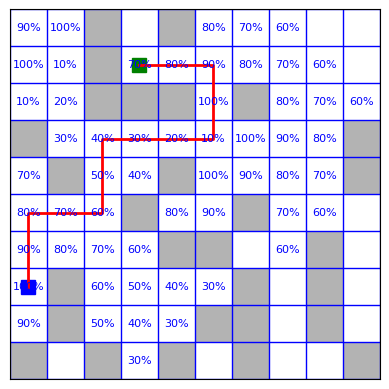

In [30]:
# Generate a 10x10 grid with random obstacles
grid_size = 10
obstacle_prob = 0.3

while True:
    grid = np.random.choice([0, 1], size=(grid_size, grid_size), p=[1 - obstacle_prob, obstacle_prob])
    start = (np.random.randint(grid_size), np.random.randint(grid_size))
    goal = (np.random.randint(grid_size), np.random.randint(grid_size))

    if grid[start[0]][start[1]] == 0 and grid[goal[0]][goal[1]] == 0:
        break

# Create the environment and agent
environment = Environment(grid, start, goal)
agent_ucs = Agent_ucs(environment)

# Solve the problem with Uniform Cost Search
solution_path, battery_levels = agent_ucs.uniform_cost_search()
print("Solution Path:", solution_path)

recharge_count = agent_ucs.recharge_count
print("Recharge Count:", recharge_count)

# Visualize the solution
visualize_grid_and_path(grid, solution_path, battery_levels)

**For A* Search**

Solution Path: [(6, 0), (6, 1), (5, 1), (4, 1), (4, 2), (4, 3), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (8, 3), (8, 2)]
Recharge Count: 10


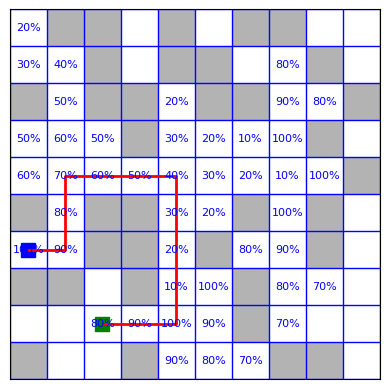

In [44]:
# Generate a 10x10 grid with random obstacles
grid_size = 10
obstacle_prob = 0.3

while True:
    grid = np.random.choice([0, 1], size=(grid_size, grid_size), p=[1 - obstacle_prob, obstacle_prob])
    start = (np.random.randint(grid_size), np.random.randint(grid_size))
    goal = (np.random.randint(grid_size), np.random.randint(grid_size))

    if grid[start[0]][start[1]] == 0 and grid[goal[0]][goal[1]] == 0:
        break

# Create the environment and agent
environment = Environment(grid, start, goal)
agent_aStar = Agent_aStar(environment)

# Solve the problem with A* Search
solution_path, battery_levels = agent_aStar.a_star_search()
print("Solution Path:", solution_path)

recharge_count = agent_aStar.recharge_count
print("Recharge Count:", recharge_count)

# Visualize the solution
visualize_grid_and_path(grid, solution_path, battery_levels)